<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/reinforcement_learning/examples/reinforcement_learning/tabular/value_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this new algorithm, we will need to define two new objects: the value table, and the algorithm itself. To shorten to code, we import the environment, policy table and algorithm classes from the previous notebook from a source code folder.

In [15]:
import sys
import os
source_path = os.path.join("source/")
sys.path.insert(0,source_path)
import environments # pylint: disable = import-error
import algorithms # pylint: disable = import-error
import tables # pylint: disable = import-error

For the value table, we define essentially a stripped down version of the policy table: here, forward is called directly to access the value of each state.

In [16]:
import numpy as np

class value_table(object):
	"""A generic tabular state value function."""

	def __init__(self, dimensions, learning_rate):
		self.table = np.zeros(dimensions)
		self.learning_rate = learning_rate

	def forward(self, state):
		"""Returns the value of the specified state."""
		return self.table[state[0]][state[1]]

	def step(self, state, error):
		"""Updates the value of the specified state."""
		self.table[state[0]][state[1]] += self.learning_rate * error

Our new algorithm is only a slight modification of the previous one, and as such it makes sense to inherit much of the behaviour of that class. The resulting class adds additional code for storing values of states along each episode, and replaces the update function so that this is used to in updates for both the values and policies of states along the episode.

In [17]:
class monte_carlo_value_baseline(algorithms.monte_carlo_returns):
	"""Contrasts returns with estimated values for policy updates."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.values = parameters['values']
		self.state_values = []

	def _per_step(self):
		"""Adds required data storage for learning post-episode."""
		super()._per_step()
		self.state_values.append(self.values.forward(self.past_state))

	def _update(self):
		"""Loops over the episode in reverse, updating state policies and values."""
		self.rewards = np.array(self.rewards)
		for index in range(len(self.states)):
			error = np.sum(self.rewards[index:]) - self.state_values[index]
			self.policy.step(self.states[index], error, self.eligibilities[index])
			self.values.step(self.states[index], error)

	def _per_episode(self):
		"""Adds additional resets relevant to learning algorithm."""
		super()._per_episode()
		self.state_values = []

For testing, we again initialize the environment, tables, and two agents using our two current algorithms.

In [18]:
environment_parameters = dict(
	trajectory_length = 20, 
	positivity_bias = 1,
	target_bias = 2,
)
environment = environments.excursions(environment_parameters)

table_dimension = (environment_parameters['trajectory_length']*2 + 1, 
				   environment_parameters['trajectory_length'] + 1)
policy1 = tables.two_action_policy_table(table_dimension, 0.15)
values2 = tables.value_table(table_dimension, 0.6)
policy2 = tables.two_action_policy_table(table_dimension, 0.15)

algorithm_parameters1 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	policy = policy1,
)
algorithm_parameters2 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	values = values2,
	policy = policy2,
)
agent1 = algorithms.monte_carlo_returns(algorithm_parameters1)
agent2 = algorithms.monte_carlo_value_baseline(algorithm_parameters2)

Next, we again evaluate the initial policy and store samples for comparison.

Initial return: -30.395999999999997


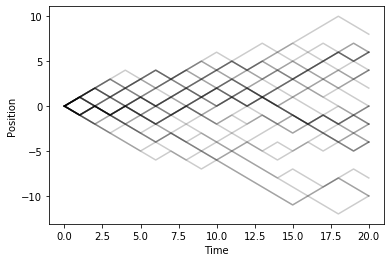

In [19]:
from matplotlib import pyplot as plt

initial_return = agent1.evaluate(1000)
agent2.average_return = initial_return
print("Initial return: %s"%(initial_return))
initial_samples = agent1.samples(30)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

Then, we train both agents using their respective algorithms, plotting their returns against eachother.

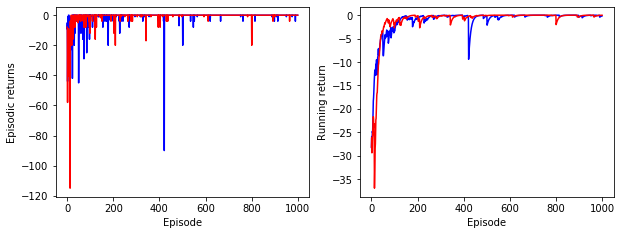

In [20]:
episodes = 1000
agent1.train(episodes)
agent2.train(episodes)

plt.figure(figsize = (10, 3.5))
plt.subplot(121)
plt.plot(agent1.returns, c = 'b')
plt.plot(agent2.returns, c = 'r')
plt.xlabel("Episode")
plt.ylabel("Episodic returns")
plt.subplot(122)
plt.plot(agent1.average_returns, c = 'b')
plt.plot(agent2.average_returns, c = 'r')
plt.xlabel("Episode")
plt.ylabel("Running return")
plt.show()

Finally, we compare both of these with the original policy.

Initial return: -30.395999999999997, agent1's final return: -0.06500000000000002, agent2's final return: -0.05000000000000001


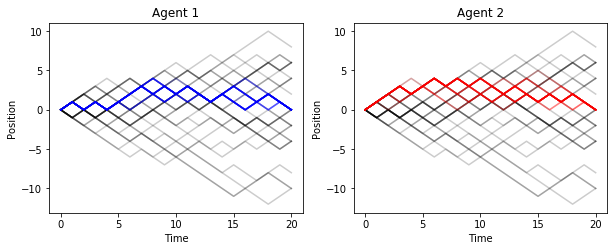

In [21]:
final_return1 = agent1.evaluate(1000)
final_return2 = agent2.evaluate(1000)
print("Initial return: %s, agent1's final return: %s, agent2's final return: %s"
%(initial_return, final_return1, final_return2))
samples1 = agent1.samples(30)
samples2 = agent2.samples(30)

plt.figure(figsize = (10, 3.5))
plt.subplot(121)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples1)[:,:,0].T, c = 'b', alpha = 0.2)
plt.title("Agent 1")
plt.xlabel("Time")
plt.ylabel("Position")
plt.subplot(122)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples2)[:,:,0].T, c = 'r', alpha = 0.2)
plt.title("Agent 2")
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()